# Iteration 2 - Remove Duplicated Images and Dividers

> **Creator**: Ryo

In [1]:
import os
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

### Variables

In [2]:
# Define the folder path
source_folder = '../data/modified-photos/histogram-equalization/clahe'
target_folder = '../data/data-understanding/1. Non Divider'
target_folder_2 = '../data/data-understanding/2. Non Duplicated'

file_prefix = 'clahe_gaussian_'

# Divider file numbers
divider_file_numbers = [
    '00915', '00951', '01077', '01292', '01540'
]

# Non-divider file numbers
non_divider_file_numbers = [
    '00914', '01018', '01139', '01366', '01396', '01429', '01612'
]

---
## Divider


### Visualize Histogram Peaks

#### *Function*

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

def show_image_intensity_distribution_with_peaks(image_path, prominence, distance):
    """
    Display an image along with its pixel intensity distribution (histogram) and highlight peaks.
    Includes a horizontal line at frequency 50000 for reference.

    Parameters:
        image_path (str): Path to the image file.
        prominence (int): Minimum prominence of each peak (controls peak sensitivity).
        distance (int): Minimum horizontal distance in bins between peaks.
    """
    # Extract filename for title
    filename = os.path.basename(image_path)
    
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Calculate histogram and find peaks
    hist_values, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    peaks, _ = find_peaks(hist_values, prominence=prominence, distance=distance)
    
    # Plot image and intensity histogram with peaks
    plt.figure(figsize=(10, 4))
    
    # Display the image without axis
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Remove axis for the image display
    plt.title(f"Image: {filename}")  # Title includes filename
    
    # Display the pixel intensity histogram
    plt.subplot(1, 2, 2)
    plt.plot(hist_values, color='blue')
    plt.plot(peaks, hist_values[peaks], "x", color='red')  # Mark peaks with red 'x'
    plt.axhline(y=50000, color='green', linestyle='--', label="Frequency 50000")  # Add horizontal line at 50000
    plt.title(f"Pixel Intensity Distribution\nTotal Peaks: {len(peaks)}")
    plt.xlabel("Pixel Intensity (0-255)")  # X-axis: intensity levels from 0 to 255
    plt.ylabel("Frequency")  # Y-axis: frequency of each intensity level
    plt.legend()  # Show legend for the horizontal line
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

### Analyze Histogram Peaks - Multi Images

#### *Function*

In [4]:
def analyze_multiple_images_hist_peaks(folder_path, file_numbers, prominence=50000, distance=50):
    """
    Analyze multiple images for pixel intensity distribution and peak detection.

    Parameters:
        folder_path (str): Path to the folder containing images.
        file_numbers (list): List of numeric parts of filenames to analyze.
        prominence (int): Minimum prominence of each peak (controls peak sensitivity).
        distance (int): Minimum horizontal distance in bins between peaks.
    """     
    for num in file_numbers:
        # Construct the full file path
        image_path = os.path.join(folder_path, f"{file_prefix}DSC{num}.JPG")
        if os.path.exists(image_path):
            print(f"Analyzing image: {image_path}")
            show_image_intensity_distribution_with_peaks(image_path, prominence=prominence, distance=distance)
        else:
            print(f"File not found: {image_path}")

### Implementation

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC00915.JPG


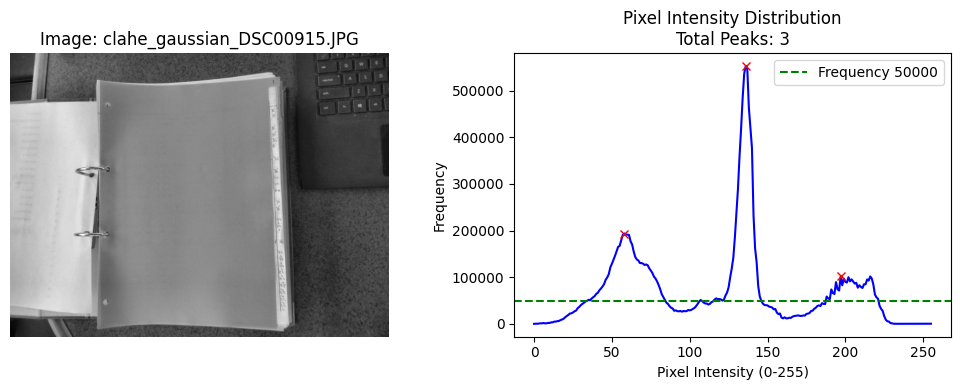

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC00951.JPG


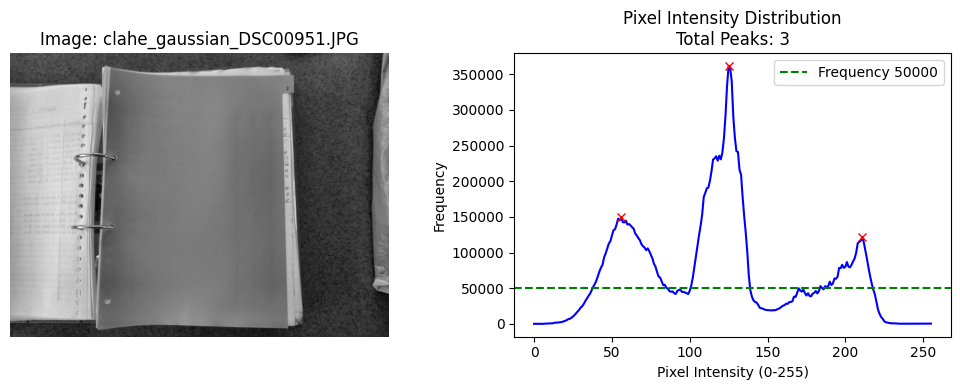

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01077.JPG


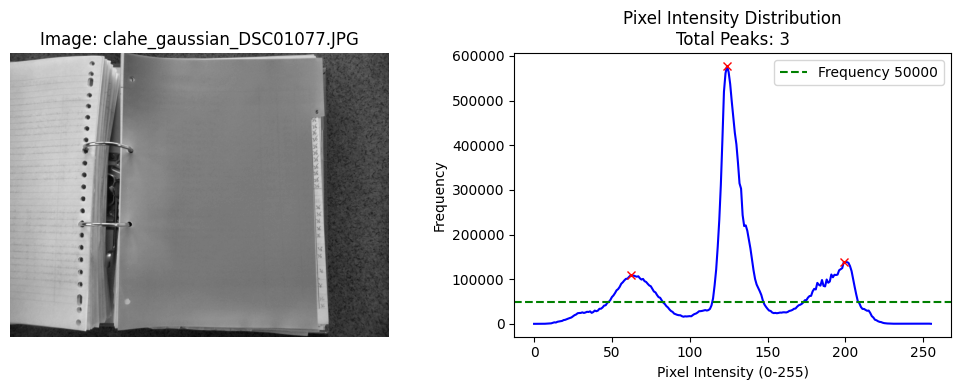

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01292.JPG


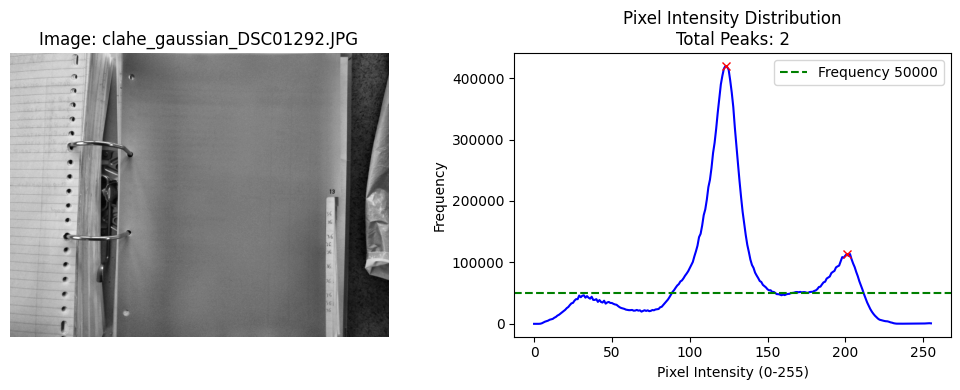

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01540.JPG


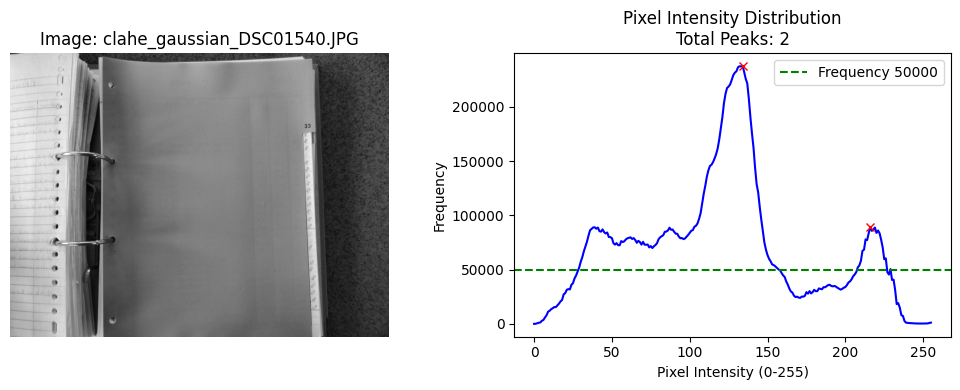

In [5]:
# Analyze the images
analyze_multiple_images_hist_peaks(source_folder, divider_file_numbers)

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC00914.JPG


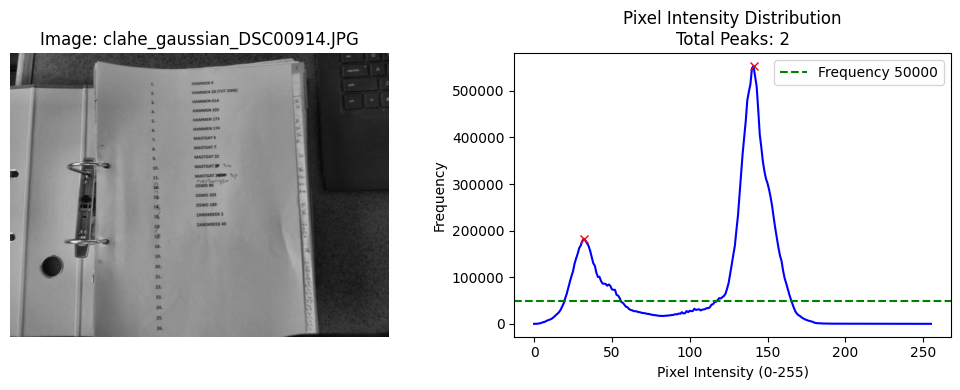

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01018.JPG


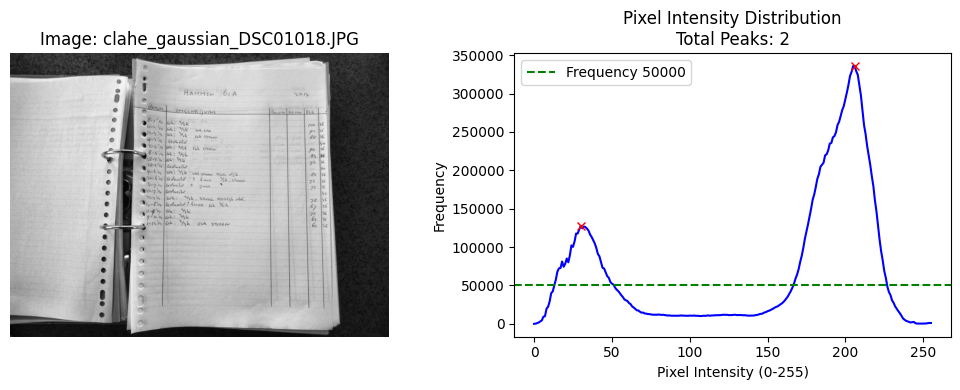

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01139.JPG


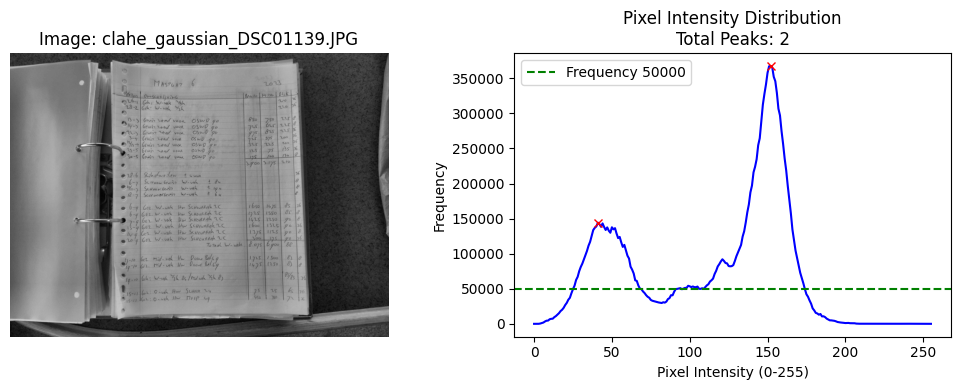

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01366.JPG


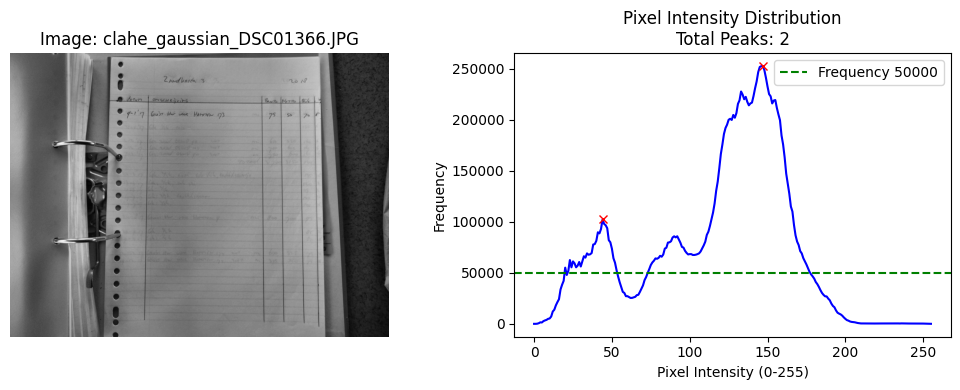

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01396.JPG


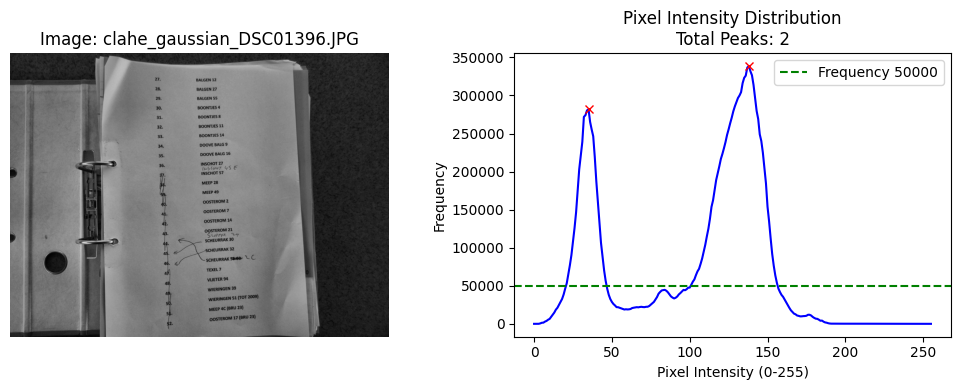

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01429.JPG


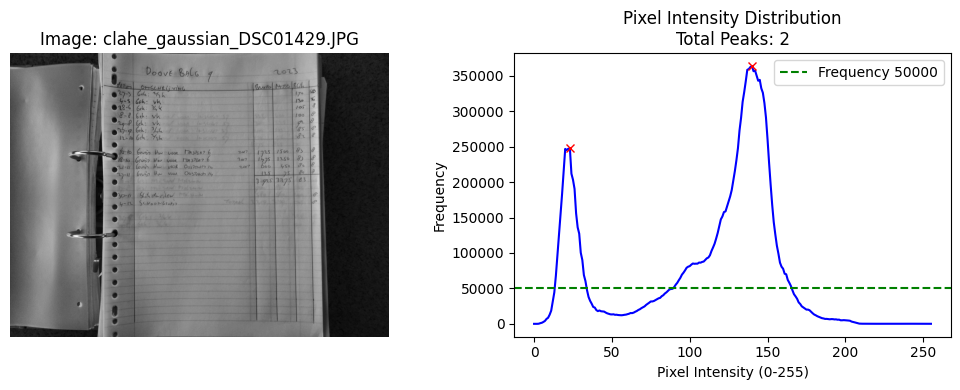

Analyzing image: ../data/modified-photos/histogram-equalization/clahe\clahe_gaussian_DSC01612.JPG


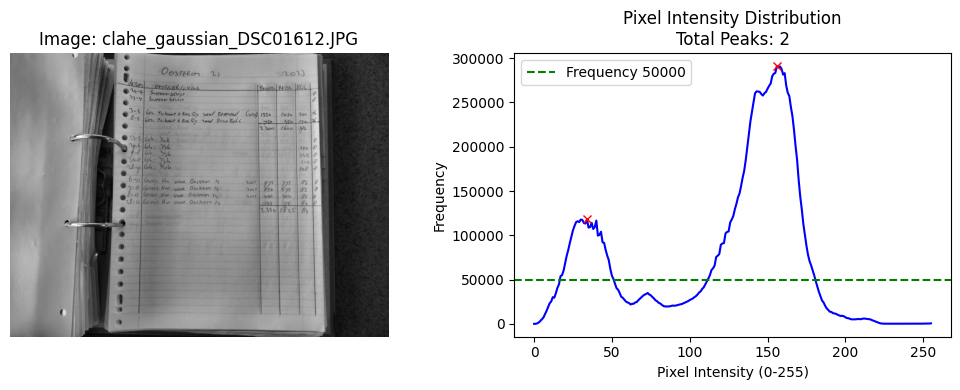

In [6]:
# Analyze the images
analyze_multiple_images_hist_peaks(source_folder, non_divider_file_numbers)

### Check Divider Pages

#### *Function*

In [7]:
def is_divider_page(image_path):
    """
    Determine if an image is likely a divider page by checking for two peaks in pixel intensity above 125.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        bool: True if at least two peaks above intensity 125 are found, False otherwise.
    """
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Calculate histogram
    hist_values, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    
    # Find peaks in the histogram
    peaks, _ = find_peaks(hist_values, prominence=50000, distance=50)

    # Count peaks with intensity above 100
    high_peaks_count = sum(peak >= 100 for peak in peaks)

    # Check if there are at least two peaks above 125
    return high_peaks_count >= 2

### Find Divider Pages

#### *Function*

In [8]:
def find_divider_pages(folder_path):
    """
    Find all images in a folder that are likely divider pages, print their numeric suffixes
    along with a total count, and return the list of numeric suffixes.

    Parameters:
        folder_path (str): Path to the folder containing images.

    Returns:
        list: Numeric suffixes of divider pages.
    """
    divider_files = []  # List to store numeric suffixes of divider pages
    valid_extensions = ('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')  # Support various image extensions
    
    # Loop through each file in the folder with tqdm for a loading bar
    for filename in tqdm(os.listdir(folder_path), desc="Processing images", leave=True):
        if filename.endswith(valid_extensions):
            image_path = os.path.join(folder_path, filename)
            
            # Check if the image is a divider page
            if is_divider_page(image_path):
                # Extract the numeric part of the filename
                number = ''.join(filter(str.isdigit, filename.split('_')[-1]))
                divider_files.append(number)  # Add only the numeric part
    
    # Print out all divider page numeric suffixes after processing
    print("\nDivider pages found:")
    for i, divider in enumerate(divider_files, start=1):
        print(f"{i}. {divider}")
    
    # Print the total count of divider pages
    print(f"\nTotal divider pages found: {len(divider_files)}")
    
    return divider_files

### Implementation

In [9]:
# Run the function to find divider files
divider_files = find_divider_pages(source_folder)

Processing images: 100%|██████████| 696/696 [03:22<00:00,  3.43it/s]


Divider pages found:
1. 00915
2. 00951
3. 00998
4. 01077
5. 01138
6. 01183
7. 01195
8. 01240
9. 01247
10. 01292
11. 01329
12. 01350
13. 01365
14. 01397
15. 01418
16. 01422
17. 01428
18. 01434
19. 01440
20. 01445
21. 01455
22. 01461
23. 01531
24. 01540
25. 01549
26. 01557
27. 01611
28. 01618
29. 01622
30. 01623
31. 01627
32. 01633

Total divider pages found: 32


### Copy Non Divider Images

#### *Function*

In [10]:
def copy_non_divider_images(source_folder, target_folder, divider_files):
    """
    Copy all non-divider images from the source folder to the target folder.

    Parameters:
        source_folder (str): Path to the folder containing original images.
        target_folder (str): Path to the folder where non-divider images will be copied.
        divider_files (list): List of numeric suffixes of divider images.
    """
    # Ensure target folder exists
    os.makedirs(target_folder, exist_ok=True)
    
    valid_extensions = ('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')
    
    # Loop through each file in the source folder with tqdm for a loading bar
    for filename in tqdm(os.listdir(source_folder), desc="Copying non-divider images", leave=True):
        if filename.endswith(valid_extensions):
            # Extract the numeric part of the filename
            number = ''.join(filter(str.isdigit, filename.split('_')[-1]))
            
            # Check if the file is NOT a divider image
            if number not in divider_files:
                source_path = os.path.join(source_folder, filename)
                target_path = os.path.join(target_folder, filename)
                
                # Copy the file to the target folder
                shutil.copy(source_path, target_path)

    print(f"Non-divider images copied to {target_folder}")

In [11]:
# Run the function to copy non-divider images
divider_pages = [
    '00915', '00951', '00998', '01077', '01138', '01183', '01195', '01240', 
    '01247', '01292', '01329', '01350', '01365', '01397', '01418', '01422', 
    '01428', '01434', '01440', '01445', '01455', '01461', '01531', '01540', 
    '01549', '01557', '01611', '01618', '01622', '01623', '01627', '01633'
]

copy_non_divider_images(source_folder, target_folder, divider_pages)

Copying non-divider images: 100%|██████████| 696/696 [00:04<00:00, 166.47it/s]

Non-divider images copied to ../data/data-understanding/1. Non Divider


### Check Information Pages

#### *Function*

In [12]:
def generate_information_files_from_dividers(divider_files):
    """
    Generate a list of file numbers by taking each divider file and subtracting 1.
    If the resulting number is also in divider_files, subtract 1 again.

    Parameters:
        divider_files (list of str): List of divider file suffixes (e.g., ['00915', '01077']).

    Returns:
        list of str: Adjusted list of file numbers.
    """
    adjusted_files = []
    
    for file in divider_files:
        # Convert file number to integer, subtract 1, and format back to 5-digit string
        adjusted_number = int(file) - 1
        adjusted_file = f"{adjusted_number:05d}"
        
        # Check if the adjusted file is in divider_files, subtract 1 again if necessary
        if adjusted_file in divider_files:
            adjusted_number -= 1
            adjusted_file = f"{adjusted_number:05d}"
        
        # Append the adjusted file to the result list
        adjusted_files.append(adjusted_file)
    
    return adjusted_files

In [13]:
# Generate the information_files list by adjusting divider files
information_files = generate_information_files_from_dividers(divider_pages)

# Print the resulting file numbers
print("Adjusted file numbers for analysis:")
print(information_files)

Adjusted file numbers for analysis:
['00914', '00950', '00997', '01076', '01137', '01182', '01194', '01239', '01246', '01291', '01328', '01349', '01364', '01396', '01417', '01421', '01427', '01433', '01439', '01444', '01454', '01460', '01530', '01539', '01548', '01556', '01610', '01617', '01621', '01621', '01626', '01632']


In [14]:
def template_matching_score(reference_image_path, target_image_path):
    """
    Calculate the template matching score between a reference image and a target image.
    
    Parameters:
        reference_image_path (str): Path to the reference image.
        target_image_path (str): Path to the target image.

    Returns:
        tuple: (float, str) The maximum matching score (between 0 and 1) or None if image loading fails, and an error message if any.
    """
    # Load the reference and target images in grayscale
    reference_image = cv2.imread(reference_image_path, cv2.IMREAD_GRAYSCALE)
    target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if images are loaded properly
    if reference_image is None:
        return None, f"Error loading reference image: {reference_image_path}"
    if target_image is None:
        return None, f"Error loading target image: {target_image_path}"
    
    # Use template matching
    res = cv2.matchTemplate(target_image, reference_image, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, _ = cv2.minMaxLoc(res)
    return max_val, None

In [15]:
def compare_with_template_and_delete(reference_image_path, target_folder, file_numbers, score_threshold=0.75):
    """
    Compare multiple images in a folder with a reference image using template matching,
    print files with scores above a threshold, and delete them from the target folder.

    Parameters:
        reference_image_path (str): Path to the reference image.
        target_folder (str): Path to the folder containing target images and from which files will be deleted.
        file_numbers (list): List of numeric parts of filenames to analyze.
        score_threshold (float): Minimum score required to consider an image as matching.
    """
    results_to_delete = []  # List to store files that match criteria for deletion
    error_messages = []  # List to store error messages

    # Loop through each file and compute template matching score
    for file_num in tqdm(file_numbers, desc="Comparing images"):
        image_path = os.path.join(target_folder, f"{file_prefix}DSC{file_num}.JPG")
        
        # Calculate similarity score
        similarity, error = template_matching_score(reference_image_path, image_path)
        
        # Store error messages if any
        if error:
            error_messages.append(error)
            continue
        
        # Only process if similarity is successfully calculated and above threshold
        if similarity is not None and similarity >= score_threshold:
            results_to_delete.append((file_num, similarity, image_path))

    # Print results above threshold
    print("\nImages with matching score above threshold:")
    for file_num, score, image_path in results_to_delete:
        print(f"{file_prefix}DSC{file_num}.JPG - Score: {score * 100:.2f}%")
        
        # Delete the file from the target folder
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted file: {image_path}")
        else:
            print(f"File not found: {image_path}")
    
    # Print any errors that occurred after loading is complete
    if error_messages:
        print("\nErrors encountered during processing:")
        for error in error_messages:
            print(error)

In [16]:
# Define the reference image path using the predefined variables
reference_image_number = '00914'  # Replace with any desired file number from non_divider_file_numbers
reference_image_path = f"{target_folder}/{file_prefix}DSC{reference_image_number}.JPG"

# Run the comparison
compare_with_template_and_delete(reference_image_path, target_folder, information_files, score_threshold=0.75)

Comparing images: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


Images with matching score above threshold:
clahe_gaussian_DSC00914.JPG - Score: 100.00%
Deleted file: ../data/data-understanding/1. Non Divider\clahe_gaussian_DSC00914.JPG
clahe_gaussian_DSC01396.JPG - Score: 78.44%
Deleted file: ../data/data-understanding/1. Non Divider\clahe_gaussian_DSC01396.JPG


---
## Duplicated Images

### Visualize Image and Check Similarity

#### *Function*

In [17]:
def compare_and_visualize_image_similarity(folder_path, file_num1, file_num2, threshold=0.4):
    """
    Compare two images to determine if they are similar based on ORB feature matching and visualize the matches.

    Parameters:
        folder_path (str): Path to the folder containing images.
        file_num1 (int): Numeric suffix of the first image file.
        file_num2 (int): Numeric suffix of the second image file.
        threshold (float): Similarity threshold (between 0 and 1). Higher means more similarity required.

    Returns:
        bool: True if images are similar based on the threshold, False otherwise.
    """
    # Construct the full file paths
    image_path1 = f"{folder_path}/{file_prefix}DSC00{file_num1}.JPG"
    image_path2 = f"{folder_path}/{file_prefix}DSC00{file_num2}.JPG"
    
    # Load the two images in grayscale
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    # Check if images loaded correctly
    if image1 is None or image2 is None:
        print(f"Error: Unable to load one or both images: {image_path1}, {image_path2}")
        return False

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect and compute ORB features for both images
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    # Use BFMatcher to find matches between the descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance (lower distance is better)
    matches = sorted(matches, key=lambda x: x.distance)

    # Calculate the number of good matches
    num_matches = len(matches)
    num_keypoints = min(len(keypoints1), len(keypoints2))
    match_ratio = num_matches / num_keypoints if num_keypoints > 0 else 0
    match_percentage = match_ratio * 100

    print(f"Match percentage for images {file_num1} and {file_num2}: {match_percentage:.2f}%")

    # Determine if images are similar based on the match ratio
    are_similar = match_ratio >= threshold

    # Visualize the matches with space between the images
    matched_image = cv2.drawMatches(
        image1, keypoints1, image2, keypoints2, matches[:50], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(12, 6))
    plt.imshow(matched_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Comparison of DSC00{file_num1} and DSC00{file_num2} - Match: {match_percentage:.2f}%")
    
    # Add spacing between the images
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.5)
    plt.show()

    return are_similar

### Implementation

In [18]:
file_num1 = 960
file_num2 = 961 
file_num3 = 962 
file_num4 = 963

Match percentage for images 960 and 961: 46.60%


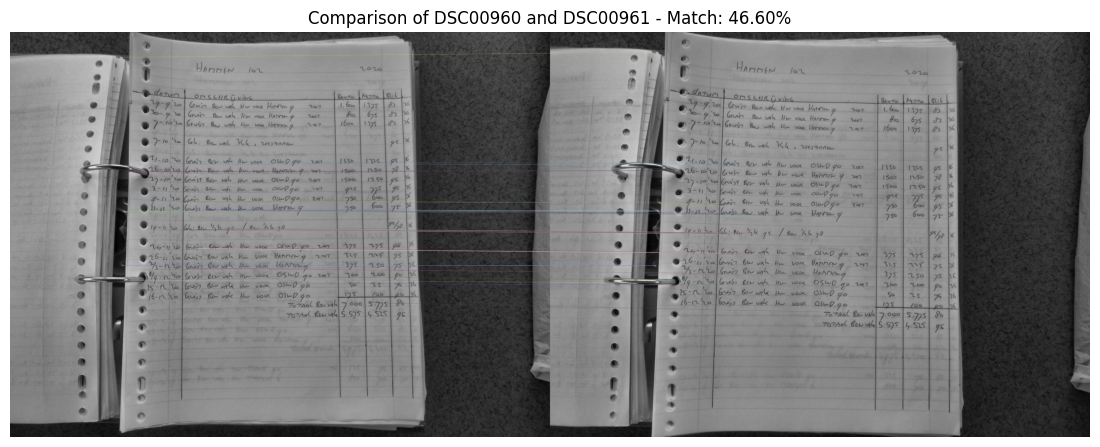

Images are similar (likely duplicates).


In [19]:
# Check if the images are similar
if compare_and_visualize_image_similarity(target_folder, file_num1, file_num2):
    print("Images are similar (likely duplicates).")
else:
    print("Images are not similar (not duplicates).")

Match percentage for images 961 and 962: 28.60%


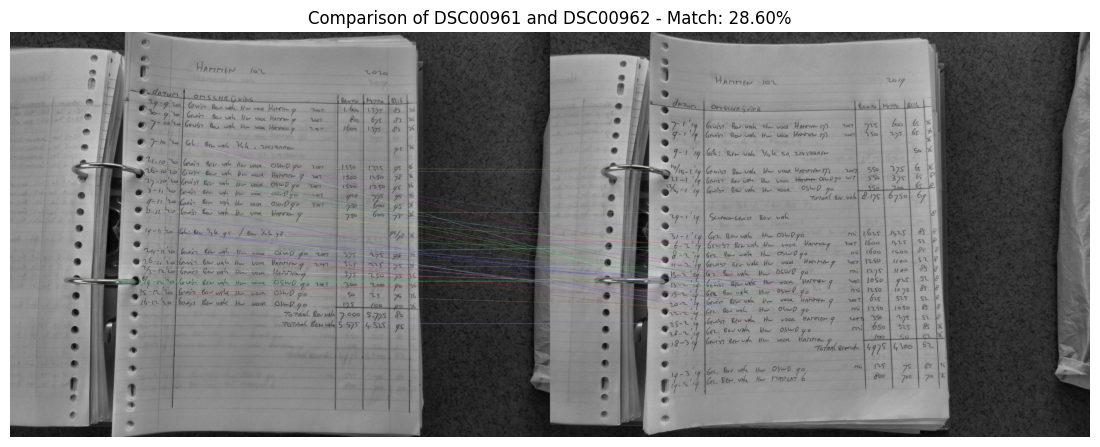

Images are not similar (not duplicates).


In [20]:
# Check if the images are similar
if compare_and_visualize_image_similarity(target_folder, file_num2, file_num3):
    print("Images are similar (likely duplicates).")
else:
    print("Images are not similar (not duplicates).")

### Measure Similarity (ORB + SSIM)

#### *Function*

In [21]:
def are_images_similar_orb_ssim(folder_path, file1, file2, orb_threshold=0.4, ssim_threshold=0.5):
    """
    Compare two images to determine if they are similar based on ORB feature matching and SSIM validation.

    Parameters:
        folder_path (str): Path to the folder containing images.
        file1 (str): Filename of the first image.
        file2 (str): Filename of the second image.
        orb_threshold (float): ORB similarity threshold (between 0 and 1).
        ssim_threshold (float): SSIM similarity threshold (between 0 and 1).

    Returns:
        float: Combined match percentage if similar, else None.
    """
    image_path1 = os.path.join(folder_path, file1)
    image_path2 = os.path.join(folder_path, file2)
    
    # Load images in grayscale
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    # Check if images loaded correctly
    if image1 is None or image2 is None:
        print(f"Error loading images: {image_path1}, {image_path2}")
        return None

    # Step 1: ORB feature matching
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    num_matches = len(matches)
    num_keypoints = min(len(keypoints1), len(keypoints2))
    orb_match_ratio = num_matches / num_keypoints if num_keypoints > 0 else 0
    orb_match_percentage = orb_match_ratio * 100

    # Only proceed with SSIM if ORB match percentage is above threshold
    if orb_match_ratio >= orb_threshold:
        # Step 2: SSIM validation
        ssim_score, _ = ssim(image1, image2, full=True)
        
        # Determine final similarity based on SSIM score
        if ssim_score >= ssim_threshold:
            combined_score = (orb_match_percentage + ssim_score * 100) / 2
            return (file1, file2, combined_score)  # Return files with combined score
        else:
            return None
    else:
        return None

### Check Duplicated Images

#### *Function*

In [22]:
def check_images_for_duplicates_orb_ssim(folder_path, orb_threshold=0.35, ssim_threshold=0.5):
    """
    Check images in a folder for duplicates using a combination of ORB and SSIM.

    Parameters:
        folder_path (str): Path to the folder containing images.
        orb_threshold (float): ORB similarity threshold.
        ssim_threshold (float): SSIM similarity threshold.

    Returns:
        list: List of duplicate pairs with match percentage.
    """
    valid_extensions = ('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(valid_extensions)])
    duplicate_pairs = []

    # Add tqdm progress bar here
    for i in tqdm(range(len(image_files) - 1), desc="Checking images for duplicates"):
        file1 = image_files[i]
        file2 = image_files[i + 1]
        
        result = are_images_similar_orb_ssim(folder_path, file1, file2, orb_threshold, ssim_threshold)
        
        if result is not None:
            duplicate_pairs.append(result)
    
    return duplicate_pairs

### Sort Duplicated Images

#### *Function*

In [23]:
def sort_and_print_duplicates(duplicate_pairs, descending=True):
    """
    Sort and print duplicate pairs by match percentage.

    Parameters:
        duplicate_pairs (list): List of tuples (file1, file2, match_percentage).
        descending (bool): If True, sort from highest to lowest match percentage.
    """
    # Sort duplicate pairs by match percentage in specified order
    sorted_pairs = sorted(duplicate_pairs, key=lambda x: x[2], reverse=descending)
    
    # Print results
    print("\nDuplicate pairs found (sorted by match percentage):")
    for file1, file2, match_percentage in sorted_pairs:
        print(f"{file1} and {file2} - Match: {match_percentage:.3f}%")

In [24]:
duplicate_pairs = check_images_for_duplicates_orb_ssim(target_folder, orb_threshold=0.35, ssim_threshold=0.4)

Checking images for duplicates: 100%|██████████| 661/661 [10:32<00:00,  1.05it/s]


In [25]:
# Sort and print results
sort_and_print_duplicates(duplicate_pairs, descending=True)


Duplicate pairs found (sorted by match percentage):
clahe_gaussian_DSC01259.JPG and clahe_gaussian_DSC01260.JPG - Match: 60.147%
clahe_gaussian_DSC01324.JPG and clahe_gaussian_DSC01325.JPG - Match: 59.215%
clahe_gaussian_DSC01366.JPG and clahe_gaussian_DSC01371.JPG - Match: 59.105%
clahe_gaussian_DSC01100.JPG and clahe_gaussian_DSC01101.JPG - Match: 59.093%
clahe_gaussian_DSC01257.JPG and clahe_gaussian_DSC01258.JPG - Match: 59.004%
clahe_gaussian_DSC01482.JPG and clahe_gaussian_DSC01483.JPG - Match: 58.336%
clahe_gaussian_DSC01098.JPG and clahe_gaussian_DSC01099.JPG - Match: 57.753%
clahe_gaussian_DSC01293.JPG and clahe_gaussian_DSC01294.JPG - Match: 57.367%
clahe_gaussian_DSC01258.JPG and clahe_gaussian_DSC01259.JPG - Match: 57.161%
clahe_gaussian_DSC01011.JPG and clahe_gaussian_DSC01012.JPG - Match: 57.107%
clahe_gaussian_DSC00960.JPG and clahe_gaussian_DSC00961.JPG - Match: 57.066%
clahe_gaussian_DSC01327.JPG and clahe_gaussian_DSC01328.JPG - Match: 56.696%
clahe_gaussian_DSC01189

### Export Non Duplicated Images to New Folder

#### *Function*

In [26]:
def remove_and_copy_unique_images(source_folder, target_folder, duplicated_file_list):
    """
    Copy unique images from the source folder to the target folder, excluding images listed for deletion.

    Parameters:
        source_folder (str): Path to the folder containing original images.
        target_folder (str): Path to the folder where unique images will be copied.
        duplicated_file_list (list): List of numeric suffixes of images to delete from the source folder.
    """
    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # Build delete_set with full filenames
    delete_set = {f"{file_prefix}DSC{suffix}.JPG" for suffix in duplicated_file_list}
    skipped_files = []  # List to store skipped filenames for later printing

    # Process each file in the source folder with tqdm progress bar
    for filename in tqdm(os.listdir(source_folder), desc="Processing images", leave=True):
        # Only process image files with expected prefix and extension
        if filename in delete_set:
            skipped_files.append(filename)  # Store filename if it is skipped
            continue  # Skip this file
        else:
            # Copy the unique file to the target folder
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(target_folder, filename)
            shutil.copy2(source_path, destination_path)

    # Print skipped files after progress bar completes
    if skipped_files:
        print("\nSkipped duplicate files:")
        for idx, skipped_file in enumerate(skipped_files, start=1):
            print(f"{idx}. {skipped_file}")
        print(f"\nTotal skipped files: {len(skipped_files)}")

    # Confirmation message
    print("\nProcess complete. All unique files have been copied to:", target_folder)

In [27]:
# List of specific file suffixes to delete with 5-character format
duplicated_file_list = [
    "00960", "01011", "01033", "01037", "01050", "01051", "01080", "01098", "01100", "01108",
    "01117", "01127", "01221", "01244", "01257", "01258", "01259", "01268", "01293", "01319",
    "01324", "01358", "01366", "01450", "01467", "01482", "01518", "01554", "01596"
]

# Run the function
remove_and_copy_unique_images(target_folder, target_folder_2, duplicated_file_list)

Processing images: 100%|██████████| 662/662 [00:05<00:00, 113.59it/s]


Skipped duplicate files:
1. clahe_gaussian_DSC00960.JPG
2. clahe_gaussian_DSC01011.JPG
3. clahe_gaussian_DSC01033.JPG
4. clahe_gaussian_DSC01037.JPG
5. clahe_gaussian_DSC01050.JPG
6. clahe_gaussian_DSC01051.JPG
7. clahe_gaussian_DSC01080.JPG
8. clahe_gaussian_DSC01098.JPG
9. clahe_gaussian_DSC01100.JPG
10. clahe_gaussian_DSC01108.JPG
11. clahe_gaussian_DSC01117.JPG
12. clahe_gaussian_DSC01127.JPG
13. clahe_gaussian_DSC01221.JPG
14. clahe_gaussian_DSC01244.JPG
15. clahe_gaussian_DSC01257.JPG
16. clahe_gaussian_DSC01258.JPG
17. clahe_gaussian_DSC01259.JPG
18. clahe_gaussian_DSC01268.JPG
19. clahe_gaussian_DSC01293.JPG
20. clahe_gaussian_DSC01319.JPG
21. clahe_gaussian_DSC01324.JPG
22. clahe_gaussian_DSC01358.JPG
23. clahe_gaussian_DSC01366.JPG
24. clahe_gaussian_DSC01450.JPG
25. clahe_gaussian_DSC01467.JPG
26. clahe_gaussian_DSC01482.JPG
27. clahe_gaussian_DSC01518.JPG
28. clahe_gaussian_DSC01554.JPG
29. clahe_gaussian_DSC01596.JPG

Total skipped files: 29

Process complete. All unique 

---
## Finalization

### Count Total Files

#### *Function*

In [28]:
def count_images_in_folder(folder_path):
    """
    Count the total number of image files in a specified folder.

    Parameters:
        folder_path (str): Path to the folder containing images.

    Returns:
        int: The total number of images in the folder.
    """
    # Valid image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')
    
    # Count files with valid extensions
    image_count = sum(1 for filename in os.listdir(folder_path) if filename.endswith(valid_extensions))
    
    # Print the result
    print(f"Total number of images in '{folder_path}': {image_count}")
    
    return image_count

#### *Implementation*

In [29]:
# Run the function to count images
count_images_in_folder(target_folder_2)

Total number of images in '../data/data-understanding/2. Non Duplicated': 633


633

In [30]:
# Run the function to count images
count_images_in_folder('../data/data-understanding/2. Non Duplicated')

Total number of images in '../data/data-understanding/2. Non Duplicated': 633


633